In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters
input_size = 3
channels1 = 8
channels2 = 16
channels3 = 32
fc_size1 = 32*2*2
fc_size2 = 50
# fc_size3 = 84
num_classes = 10
num_epochs = 50
learning_rate = 0.01
batch_size = 64
# momentum = 0.9

In [4]:
# CIFAR10 dataset

# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -zxvf cifar-10-python.tar.gz ../../data

train_dataset = torchvision.datasets.CIFAR10(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


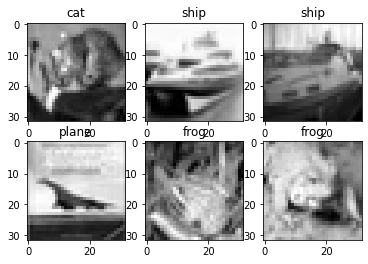

In [5]:
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.title(classes[example_targets[i].item()])
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [6]:
# Fully connected neural network with two hidden layers
class CNN(nn.Module):
    def __init__(self, input_size, channels1, channels2, channels3, fc_size1, fc_size2, num_classes):
        super(CNN, self).__init__()
        # self.conv1 = nn.Conv2d(input_size, channels1, kernel_size=5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(channels1, channels2, kernel_size=5)
        # self.fc1 = nn.Linear(fc_size1, fc_size2)
        # self.fc2 = nn.Linear(fc_size2, fc_size3)
        # self.fc3 = nn.Linear(fc_size3, num_classes)
        self.conv1 = nn.Conv2d(input_size, channels1, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(channels1, channels2, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(channels2, channels3, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(fc_size1, fc_size2)
        self.fc2 = nn.Linear(fc_size2, num_classes)
        # self.fc_size1 = fc_size1


    def forward(self, x):
        # x = self.conv1(x)
        # x = F.relu(x)
        # x = self.pool(x)
        # x = self.conv2(x)
        # x = F.relu(x)
        # x = self.pool(x)
        # x = x.view(-1, fc_size1) # Flatten
        # x = self.fc1(x)
        # x = F.relu(x)
        # x = self.fc2(x)
        # x = F.relu(x)
        # x = self.fc3(x)
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, fc_size1) # Flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # no activation and no softmax at the end
        return x

model = CNN(input_size, channels1, channels2, channels3, fc_size1, fc_size2, num_classes).to(device)

In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [8]:
# Train the model
n_total_steps = len(train_loader)
train_acc = []
test_acc = []
for epoch in range(num_epochs):
    n_correct = 0
    n_samples = 0
    for i, (images, labels) in enumerate(train_loader):  
        # original shape: [100, 1, 28, 28]
        # resized: [100, 784]
        # print(images.shape)
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Calculating Train Accuracy
        if i == 0:
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                for images, labels in train_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    n_correct += (predicted == labels).sum().item()
                    n_samples += labels.size(0)
                train_acc.append(100*n_correct/n_samples)

            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    # max returns (value ,index)
                    _, predicted = torch.max(outputs.data, 1)
                    n_samples += labels.size(0)
                    n_correct += (predicted == labels).sum().item()
                test_acc.append(100.0 * n_correct / n_samples)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
        if(i == 0):
            print(f'Train Accuracy: {train_acc[-1]}, Test Accuracy: {test_acc[-1]}')

Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch [1/50], Step [100/782], Loss: 2.3010
Epoch [1/50], Step [200/782], Loss: 2.2954
Epoch [1/50], Step [300/782], Loss: 2.2847
Epoch [1/50], Step [400/782], Loss: 2.0771
Epoch [1/50], Step [500/782], Loss: 2.0922
Epoch [1/50], Step [600/782], Loss: 2.0436
Epoch [1/50], Step [700/782], Loss: 1.8221
Train Accuracy: 30.228, Test Accuracy: 30.07
Epoch [2/50], Step [100/782], Loss: 1.7299
Epoch [2/50], Step [200/782], Loss: 1.8152
Epoch [2/50], Step [300/782], Loss: 1.6374
Epoch [2/50], Step [400/782], Loss: 1.4973
Epoch [2/50], Step [500/782], Loss: 1.4991
Epoch [2/50], Step [600/782], Loss: 1.4314
Epoch [2/50], Step [700/782], Loss: 1.5830
Train Accuracy: 44.502, Test Accuracy: 43.89
Epoch [3/50], Step [100/782], Loss: 1.4416
Epoch [3/50], Step [200/782], Loss: 1.5685
Epoch [3/50], Step [300/782], Loss: 1.2717
Epoch [3/50], Step [400/782], Loss: 1.4068
Epoch [3/50], Step [500/782], Loss: 1.3599
Epoch [3/50], Step [600/782], Loss: 1.5883
Epoch [3

KeyboardInterrupt: 

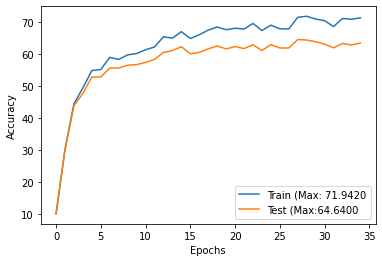

In [10]:
# plt.plot(list(range(len(acc))), acc, label=f'Train (Max: {max(total_train_acc):.4f}')
# plt.show()
plt.plot(list(range(len(train_acc))), train_acc, label=f'Train (Max: {max(train_acc):.4f}')
plt.plot(list(range(len(test_acc))), test_acc, label=f'Test (Max:{max(test_acc):.4f}')
# plt.title(f'{num_clients} Clients: Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
# plt.savefig(f'./Results/{num_clients} Clients Accuracy vs. Epochs.png', bbox_inches='tight')
plt.show()

In [11]:
# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 63.1 %
